<a href="https://colab.research.google.com/github/mausci69/Tweet-Emotion-Recognition/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [28]:
!pip install nlp

The model is actually fast, so we can train it without GPU

<em>#!nvidia-smi</em>

In [55]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show();

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show();

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [31]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [32]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [33]:
train_df = dataset['train']
valid_df = dataset['validation']
test_df = dataset['test']

In [34]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

tweets, labels = get_tweet(train_df)

In [35]:
for i in range(5):
  print(tweets[i], '-', labels[i])

i didnt feel humiliated - sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake - sadness
im grabbing a minute to post i feel greedy wrong - anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property - love
i am feeling grouchy - anger


## Task 4: Tokenizer

1. Tokenizing the tweets

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(tweets)

In [37]:
print(tweets[0])
print(tokenizer.texts_to_sequences([tweets[0]]))

i didnt feel humiliated
[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

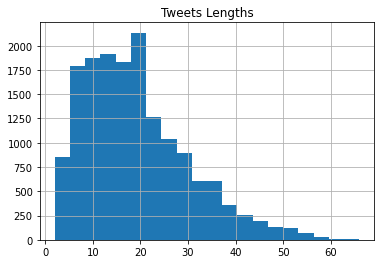

In [38]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=20)
plt.title('Tweets Lengths')
plt.grid()
plt.show();

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 40

def get_sequences(tokenizer, texts):
  sequences = tokenizer.texts_to_sequences(texts)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [40]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [41]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [42]:
classes = set(labels)
print(classes)

{'love', 'surprise', 'fear', 'anger', 'joy', 'sadness'}


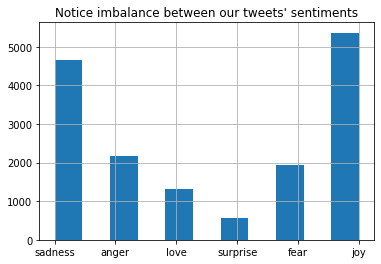

In [43]:
plt.hist(labels, bins=11)
plt.title("Notice imbalance between our tweets' sentiments")
plt.grid()
plt.show();

In [44]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [45]:
class_to_index

{'anger': 3, 'fear': 2, 'joy': 4, 'love': 0, 'sadness': 5, 'surprise': 1}

In [46]:
index_to_class

{0: 'love', 1: 'surprise', 2: 'fear', 3: 'anger', 4: 'joy', 5: 'sadness'}

In [47]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [48]:
train_labels = names_to_ids(labels)
train_labels[0]

5

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [49]:
model = tf.keras.Sequential([
            tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
            tf.keras.layers.Dense(6, activation='softmax')                             
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [51]:
valid_tweets, valid_labels = get_tweet(valid_df)
valid_seq = get_sequences(tokenizer, valid_tweets)
valid_labels = names_to_ids(valid_labels)

In [52]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [53]:
history = model.fit(padded_train_seq, train_labels, epochs=20, validation_data=(val_seq, val_labels), verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
500/500 [==============================] - 25s 40ms/step - loss: 1.2469 - accuracy: 0.5070 - val_loss: 0.7376 - val_accuracy: 0.7315
Epoch 2/20
500/500 [==============================] - 19s 38ms/step - loss: 0.5377 - accuracy: 0.7996 - val_loss: 0.5394 - val_accuracy: 0.8345
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2724 - accuracy: 0.9084 - val_loss: 0.4189 - val_accuracy: 0.8595
Epoch 4/20
500/500 [==============================] - 18s 37ms/step - loss: 0.1779 - accuracy: 0.9402 - val_loss: 0.3975 - val_accuracy: 0.8750
Epoch 5/20
500/500 [==============================] - 18s 37ms/step - loss: 0.1369 - accuracy: 0.9544 - val_loss: 0.4191 - val_accuracy: 0.8795
Epoch 6/20
500/500 [==============================] - 19s 37ms/step - loss: 0.1004 - accuracy: 0.9676 - val_loss: 0.4969 - val_accuracy: 0.8640
Epoch 7/20
500/500 [==============================] - 19s 37ms/step - loss: 0.0864 - accuracy: 0.9715 - val_loss: 0.4291 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

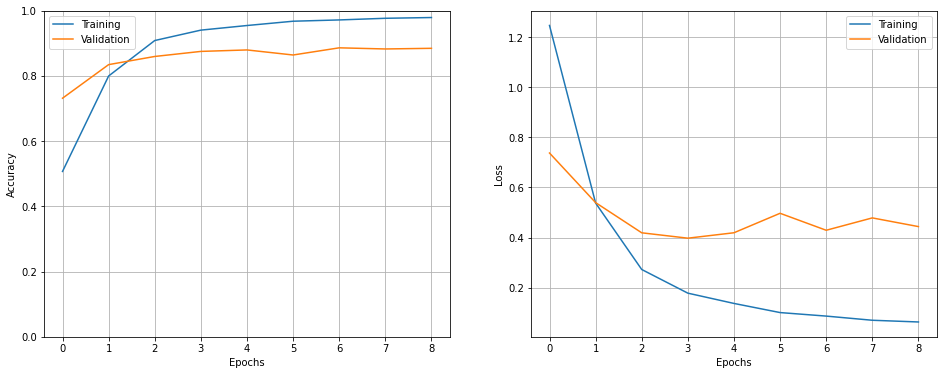

In [56]:
show_history(history)

In [57]:
test_tweets, test_labels = get_tweet(test_df)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [59]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 11ms/step - loss: 0.5013 - accuracy: 0.8700


[0.5013071298599243, 0.8700000047683716]

In [60]:
i = random.randint(0, len(test_labels)-1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel like most teams would have appeased jackson at this point but the eagles are terribly stubborn
Emotion: anger
Predicted Emotion: anger


In [64]:
preds = np.argmax(model.predict(test_seq), axis=-1)

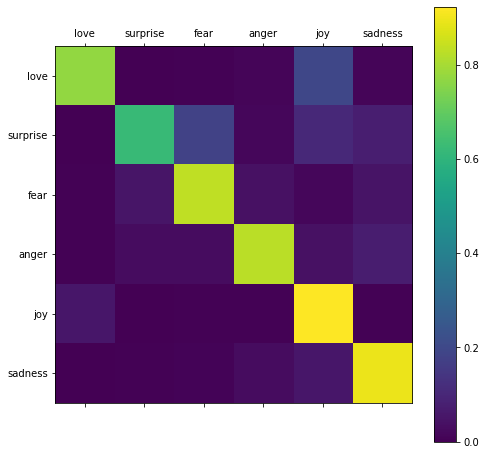

In [65]:
show_confusion_matrix(test_labels, preds, list(classes))